In [1]:
import goodfire

client = goodfire.Client(GOODFIRE_API_KEY)

In [12]:
import pandas as pd

df = pd.read_csv("data/spam_messages_train.csv")

In [13]:
df

,label,text
0,ham,"Funny fact Nobody teaches volcanoes 2 erupt, t..."
1,ham,I sent my scores to sophas and i had to do sec...
2,spam,We know someone who you know that fancies you....
3,ham,Only if you promise your getting out as SOON a...
4,spam,Congratulations ur awarded either �500 of CD g...
...,...,...
47387,ham,please change the sitara tickets dating back t...
47388,spam,from mr . silas sankoh ecobank benin rue du go...
47389,ham,just to get things stirred up : the estate wil...
47390,ham,sorry for the oversight . bill - - - - - origi...


In [11]:
variant = goodfire.Variant("meta-llama/Meta-Llama-3-8B-Instruct")

In [18]:
positive_examples = df[df['label'] == 'spam']
negative_examples = df[df['label'] == 'ham']

FEATURE_COMPUTE_SIZE = 50
CLASSIFIER_FULL_SET_SIZE = 150

In [110]:
spam_features, ham_features = client.features.contrast(
    dataset_1=[
      [
          {"role": "user", "content": f"Is the following message spam or ham? {text}"},
          {"role": "assistant", "content": "spam"}
      ] for text in positive_examples[0:FEATURE_COMPUTE_SIZE]['text'].tolist()
    ],
    dataset_2=[
      [
          {"role": "user", "content": f"Is the following message spam or ham? {text}"},
          {"role": "assistant", "content": "ham"}
      ] for text in negative_examples[0:FEATURE_COMPUTE_SIZE]['text'].tolist()
    ],
    dataset_1_feature_rerank_query="spam",
    model=variant,
    top_k=50
)
features_to_look_at = spam_features | ham_features
features_to_look_at

FeatureGroup([
   0: "Phishing and social engineering tactics",
   1: "Limited-time offers and scarcity in marketing",
   2: "Call-to-action phrases in marketing content",
   3: "Free or low-cost offerings across various domains and languages",
   4: "Start of a new input or message in the conversation",
   5: "Encoded or encrypted alphanumeric sequences",
   6: "Start of a new user query or conversation",
   7: "SMS and text messaging services",
   8: "Early 2000s internet culture and technology references",
   ...
   249: "feature_59618"
])

In [17]:
from itertools import combinations


class FeatureMixer:
  def __init__(self, feature_group):
    self.feature_group = feature_group

  def grid(self, k_features_per_combo: int =2):
    """Perform a grid search over all possible combinations of features"""

    # Get all possible combinations of features
    return list(combinations(self.feature_group, k_features_per_combo))


In [20]:
import pandas as pd
import concurrent.futures as futures
import tqdm

def _get_feature_acts_for_sample_class(
    sample_class: pd.DataFrame,
    features_to_use_for_classification: goodfire.FeatureGroup,
    k=len(features_to_look_at),
):
  if k < len(features_to_use_for_classification):
    raise ValueError("k must be greater than the number of features to use for classification")

  samples = []
  for idx, row in tqdm.tqdm(sample_class[0:CLASSIFIER_FULL_SET_SIZE].iterrows()):
    text = row['text']
    context = client.features.inspect(
        [
            {
                "role": "user",
                "content": f"is the following good or bad for investors? {text}"
            }
        ],
        model=variant,
        features=features_to_use_for_classification,
    )

    features = context.top(k=k)
    samples.append(features)

  return samples


print("Computing spam features...")
positive_class_features = _get_feature_acts_for_sample_class(positive_examples, features_to_look_at, k=100)

print("Computing ham features...")
negative_class_features = _get_feature_acts_for_sample_class(negative_examples, features_to_look_at, k=100)


Computing spam features...


150it [01:33,  1.61it/s]


Computing ham features...


150it [01:30,  1.66it/s]


In [79]:
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score
import numpy as np
import tqdm


# Grid search may take a while, you can curate the feature list to speed this process up significantly
def train_tree(x, y, depth):
  train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.5, random_state=42)

  # Create a nice regularized tree
  model = tree.DecisionTreeClassifier(
      max_depth=depth,
      min_samples_leaf=len(train_x) // 20,
      random_state=42
  )

  model.fit(train_x, train_y)

  pred = model.predict(test_x)

  # Calculate the f1 score of the model
  accuracy = balanced_accuracy_score(test_y, pred)
  score = f1_score(test_y, pred)

  return model, pred, score, accuracy


def find_best_combo(features, k_features_per_combo = 2):
  combos = FeatureMixer(features).grid(k_features_per_combo=k_features_per_combo)
  best_combo = None
  best_model = None
  best_score = 0
  best_accuracy = 0

  MAX_WORKERS = 8

  futures_list = []

  with futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    for combo in combos:
      def _test_combo(combo):
        def _select_feature_acts(combo, row):
          output = []
          for index, feature in enumerate(combo):
            for feature_act in row:
              if feature_act.feature.uuid == feature.uuid:
                output.append(feature_act.activation)
                break

          return output

        x_negative = [_select_feature_acts(combo, row) for row in negative_class_features]
        x_positive = [_select_feature_acts(combo, row) for row in positive_class_features]

        y_negative = [-1] * len(x_negative)
        y_positive = [1] * len(x_positive)

        x = x_negative + x_positive
        y = y_negative + y_positive

        model, pred, score, accuracy = train_tree(x, y, depth=len(combo))

        return model, pred, score, accuracy, combo

      futures_list.append(executor.submit(_test_combo, combo))

    for future in tqdm.tqdm(futures_list):
      model, pred, score, accuracy, combo = future.result()

      if score > best_score:
        best_score = score
        best_combo = combo
        best_model = model
        best_accuracy = accuracy

  return best_combo, best_score, best_model, best_accuracy


best_combo_at_k = {}
for i in range(3):
  best_combo, best_score, best_model, best_accuracy = find_best_combo(features_to_look_at, k_features_per_combo = i + 1)
  print(i + 1, best_combo, best_score, best_accuracy, best_model)
  best_combo_at_k[i + 1] = (best_combo, best_score, best_model)


100%|██████████| 53/53 [00:00<00:00, 125.95it/s]


1 (Feature("Phone number detection, especially area codes 43 and 69"),) 0.9411764705882353 0.9444444444444444 DecisionTreeClassifier(max_depth=1, min_samples_leaf=7, random_state=42)


100%|██████████| 1378/1378 [00:20<00:00, 67.00it/s]


2 (Feature("URL and HTML tag closures"), Feature("Trademarks and brand names for consumer electronics")) 0.9496402877697842 0.9519230769230769 DecisionTreeClassifier(max_depth=2, min_samples_leaf=7, random_state=42)


100%|██████████| 23426/23426 [06:39<00:00, 58.70it/s]


3 (Feature("Phishing and social engineering tactics"), Feature("URL and HTML tag closures"), Feature("Trademarks and brand names for consumer electronics")) 0.9496402877697842 0.9519230769230769 DecisionTreeClassifier(max_depth=3, min_samples_leaf=7, random_state=42)


In [80]:
# Inspect features to understand their nuances better
best_individual_feature = best_combo_at_k[3][0][0]

print(best_individual_feature)

client.features._experimental.neighbors(best_individual_feature)
# Seems to be associated with more precise numbers! Corraborated by checking samples where this feature was particularly active.

Feature("Phishing and social engineering tactics")


FeatureGroup([
   0: "Cautionary advice for online security",
   1: "Email composition and HTML formatting",
   2: "Detection of misleading financial or employment claims",
   3: "Malicious software and cyber attack techniques",
   4: "Spam and automated messaging techniques",
   5: "Identity theft and financial fraud risks",
   6: "The user has requested a new scenario or story",
   7: "Receiving or blocking unwanted digital communication",
   8: "Manipulative and coercive persuasion techniques",
   9: "Password recovery and account reset processes"
])

In [81]:
# Function to visualize the decision tree
def visualize_tree(tree_model, features, class_names=['negative', 'positive']):
    import graphviz
    dot_data = tree.export_graphviz(
        tree_model, 
        out_file=None, 
        feature_names=[feature.label for feature in features],
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    return graph

DecisionTreeClassifier(max_depth=3, min_samples_leaf=7, random_state=42)
(Feature("Phishing and social engineering tactics"), Feature("URL and HTML tag closures"), Feature("Trademarks and brand names for consumer electronics"))
0.9496402877697842


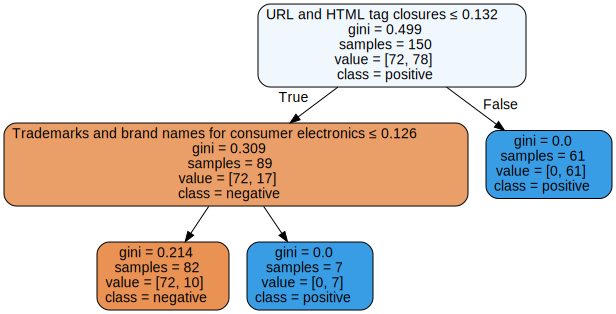

In [84]:
# Anyways let's look at the best overall tree
BEST_TREE_INDEX = 3
best_features = best_combo_at_k[BEST_TREE_INDEX][0]
best_score = best_combo_at_k[BEST_TREE_INDEX][1]
best_tree = best_combo_at_k[BEST_TREE_INDEX][2]

# Visualize the tree
print(best_tree)
print(best_features)
print(best_score)
visualize_tree(best_tree, best_features)

AttributeError: 'Variant' object has no attribute 'completions'